In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

In [2]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# set seed for reproducibilty
SEED = 50

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**DATA PREPROCESSING AND VISUALIZATION**

In [4]:
# read the dataset
df = pd.read_csv('GOOG.csv')
df.head(10)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,19-08-2004,2.390042,2.490664,897427216,2.591785,2.499133,2.499133
1,20-08-2004,2.503118,2.515820,458857488,2.716817,2.697639,2.697639
2,23-08-2004,2.716070,2.758411,366857939,2.826406,2.724787,2.724787
3,24-08-2004,2.579581,2.770615,306396159,2.779581,2.611960,2.611960
4,25-08-2004,2.587302,2.614201,184645512,2.689918,2.640104,2.640104
5,26-08-2004,2.606729,2.613952,142572401,2.688672,2.687676,2.687676
6,27-08-2004,2.632383,2.692408,124826132,2.705360,2.643840,2.643840
7,30-08-2004,2.540727,2.622171,104429967,2.627402,2.540727,2.540727
8,31-08-2004,2.544463,2.547950,98825037,2.583068,2.549693,2.549693
9,01-09-2004,2.482445,2.557912,183633734,2.564637,2.496891,2.496891


In [5]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612 entries, 0 to 4611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4612 non-null   object 
 1   Low             4612 non-null   float64
 2   Open            4612 non-null   float64
 3   Volume          4612 non-null   int64  
 4   High            4612 non-null   float64
 5   Close           4612 non-null   float64
 6   Adjusted Close  4612 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 252.3+ KB


In [6]:
# select only the relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

train_length = int(len(df)*0.8)
val_length = int(len(df)*0.1)

# split the dataset into training, validation and test set
train_data = df[:train_length]
valid_data = df[train_length:train_length+val_length]
test_data = df[train_length+val_length:]

In [7]:
# scaler to scale the data using standard scaling
scaler = MinMaxScaler()

train_scaled_data = scaler.fit_transform(train_data)
valid_scaled_data = scaler.transform(valid_data)
test_scaled_data = scaler.transform(test_data)

print(train_scaled_data.shape)
print(valid_scaled_data.shape)
print(test_scaled_data.shape)

(3689, 5)
(461, 5)
(462, 5)


In [8]:
class StockDataset(Dataset):
    def __init__(self, data, N):

        self.data = data

        self.N = N

    def __len__(self):
        return len(self.data) - self.N

    def __getitem__(self, idx):
        # get the features for the last N days
        x = self.data[idx:idx + self.N, :]

        # get the closing price of the next day as the target
        y = self.data[idx + self.N, 3]

        # convert to PyTorch tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return x, y

In [9]:
# number of days to look back
N = 30

# instantiate the datasets
train_data = StockDataset(train_scaled_data, N)
valid_data = StockDataset(valid_scaled_data, N)
test_data = StockDataset(test_scaled_data, N)

In [10]:
# batch size
BATCH_SIZE = 32

# create the dataloaders
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
x,y = next(iter(train_dataloader))

print(x.shape,y.shape)

torch.Size([32, 30, 5]) torch.Size([32])


In [12]:
best_model = None
best_model_name = ''
best_rmse = float('inf')
best_hidden_dim = None

**TRAINING**

In [13]:
# function to train the model
def train(model, dataloader, criterion, optimizer):
    # set model to trainin mode
    model.train()

    epoch_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        # forward pass
        preds = model(x).squeeze()

        # calculate the loss
        loss = criterion(preds, y)

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the weights
        optimizer.step()

        # update the loss
        epoch_loss += loss.item()

    # get the average loss
    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [14]:
# function to unscale the scaled prices
def unscale_price(scaled_prices, scaler):
    data_min = scaler.data_min_[3]
    data_max = scaler.data_max_[3]

    # unscale the prices
    unscaled_prices = scaled_prices * (data_max - data_min) + data_min
    return unscaled_prices


# function to evaluate a model and plot the predicted values and actual values
def evaluate(model, dataset, scaler):
    actual_price = []
    pred_price = []

    # set model to evaluation mode
    model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            x,y = dataset[i]
            x, y = x.to(device), y.to(device)

            # add a batch dimension
            x = x.unsqueeze(0)

            pred = model(x).squeeze()

            actual_price.append(y.item())
            pred_price.append(pred.item())

    # unscale the actual closing prices
    actual_price = unscale_price(np.array(actual_price), scaler)

    # unscale the predicted closing prices
    pred_price = unscale_price(np.array(pred_price), scaler)

    # calculate the root mean-squared error
    rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
    print(f"RMSE: {rmse:.4f}")

    # plot the actual and predicted closing prices
    plt.figure(figsize=(10, 6))
    plt.plot(actual_price, label='Actual Stock Prices', color='red')
    plt.plot(pred_price, label='Predicted Stock Prices', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Closing Stock Price')
    plt.title('Actual vs. Predicted Stock Prices')
    plt.legend()
    plt.show()

    return rmse

**VANILLA RNN (BASELINE)**

In [15]:
class Baseline(nn.Module):
    def __init__(self, feature_size, hidden_dim):

        super().__init__()

        self.rnn = nn.RNN(feature_size,
                          hidden_dim,
                          batch_first=True)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        hidden = hidden.squeeze()

        out = self.fc(hidden)

        return out

In [16]:
feature_size = 5
hidden_dim = 16

model = Baseline(feature_size, hidden_dim).to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [18]:
epochs = 100

In [19]:
for epoch in range(epochs):

    # train the model on the training set
    train_loss = train(model, train_dataloader, criterion, optimizer)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000095
Epoch 20 | Train Loss: 0.000080
Epoch 30 | Train Loss: 0.000075
Epoch 40 | Train Loss: 0.000071
Epoch 50 | Train Loss: 0.000071
Epoch 60 | Train Loss: 0.000059
Epoch 70 | Train Loss: 0.000067
Epoch 80 | Train Loss: 0.000057
Epoch 90 | Train Loss: 0.000056
Epoch 100 | Train Loss: 0.000055


RMSE: 2.6009


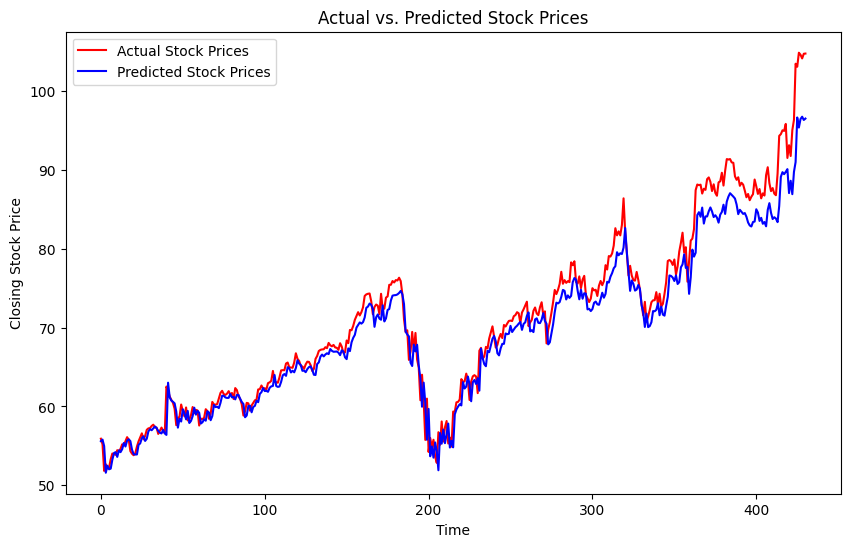

In [20]:
rmse = evaluate(model, valid_data, scaler)
if rmse < best_rmse:
    best_rmse = rmse
    best_model = model
    best_model_name = 'Vanilla RNN'
    best_hidden_dim = 16

**LSTM**

In [21]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.LSTM(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, (hidden,cell) = self.rnn(x)

        # get the hidden state from the last layer
        hidden = hidden[-1,:,:]

        out = self.fc(hidden)

        return out

In [22]:
feature_size = 5
#hidden_dim = 64
num_layers = 2

#model = LSTM(feature_size, hidden_dim, num_layers).to(device)

In [23]:
#optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [24]:
epochs = 100

Training LSTM with hidden state size: 32
Epoch 10 | Train Loss: 0.000178
Epoch 20 | Train Loss: 0.000138
Epoch 30 | Train Loss: 0.000112
Epoch 40 | Train Loss: 0.000089
Epoch 50 | Train Loss: 0.000077
Epoch 60 | Train Loss: 0.000065
Epoch 70 | Train Loss: 0.000068
Epoch 80 | Train Loss: 0.000062
Epoch 90 | Train Loss: 0.000072
Epoch 100 | Train Loss: 0.000064
RMSE: 2.2974


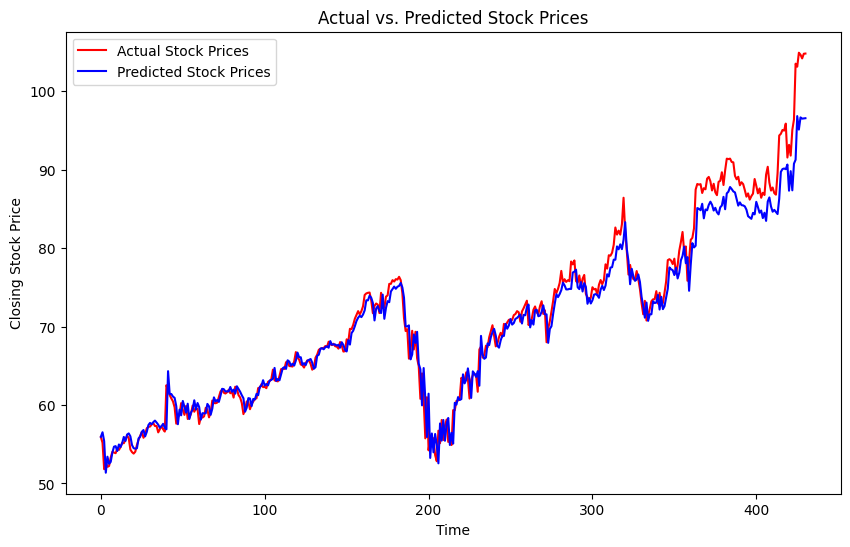




Training LSTM with hidden state size: 64
Epoch 10 | Train Loss: 0.000170
Epoch 20 | Train Loss: 0.000111
Epoch 30 | Train Loss: 0.000088
Epoch 40 | Train Loss: 0.000077
Epoch 50 | Train Loss: 0.000064
Epoch 60 | Train Loss: 0.000062
Epoch 70 | Train Loss: 0.000067
Epoch 80 | Train Loss: 0.000062
Epoch 90 | Train Loss: 0.000055
Epoch 100 | Train Loss: 0.000057
RMSE: 3.5564


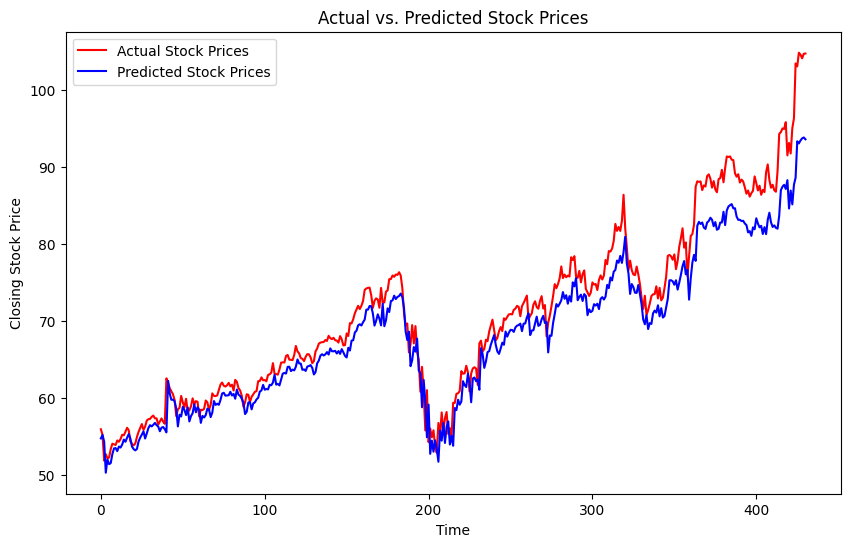




Training LSTM with hidden state size: 128
Epoch 10 | Train Loss: 0.000166
Epoch 20 | Train Loss: 0.000122
Epoch 30 | Train Loss: 0.000090
Epoch 40 | Train Loss: 0.000064
Epoch 50 | Train Loss: 0.000107
Epoch 60 | Train Loss: 0.000066
Epoch 70 | Train Loss: 0.000057
Epoch 80 | Train Loss: 0.000058
Epoch 90 | Train Loss: 0.000078
Epoch 100 | Train Loss: 0.000054
RMSE: 2.7797


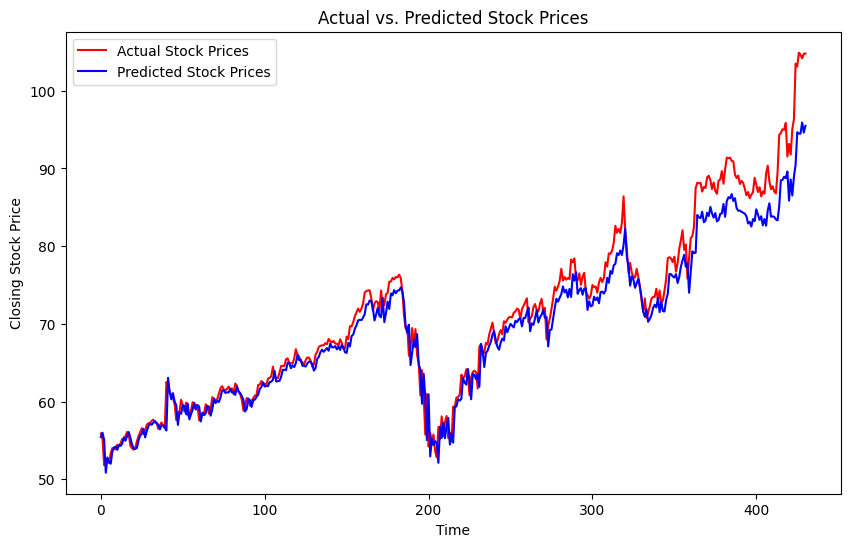

In [25]:
for hidden_dim in [32,64,128]:
    print(f"Training LSTM with hidden state size: {hidden_dim}")
    model = LSTM(feature_size, hidden_dim, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):

        # train the model on the training set
        train_loss = train(model, train_dataloader, criterion, optimizer)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

    rmse = evaluate(model, valid_data, scaler)
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_model_name = 'LSTM'
        best_hidden_dim = hidden_dim

    print("\n\n")

**GRU**

In [ ]:
class GRU(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.GRU(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        # get the hidden state from the last layer
        hidden = hidden[-1,:,:]

        out = self.fc(hidden)

        return out

In [ ]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = GRU(feature_size, hidden_dim, num_layers).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [ ]:
epochs = 100

In [ ]:
for epoch in range(epochs):

    # train the model on the training set
    train_loss = train(model, train_dataloader, criterion, optimizer)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000075
Epoch 20 | Train Loss: 0.000071
Epoch 30 | Train Loss: 0.000103
Epoch 40 | Train Loss: 0.000070
Epoch 50 | Train Loss: 0.000073
Epoch 60 | Train Loss: 0.000063
Epoch 70 | Train Loss: 0.000066
Epoch 80 | Train Loss: 0.000061
Epoch 90 | Train Loss: 0.000058
Epoch 100 | Train Loss: 0.000064


RMSE: 2.5587


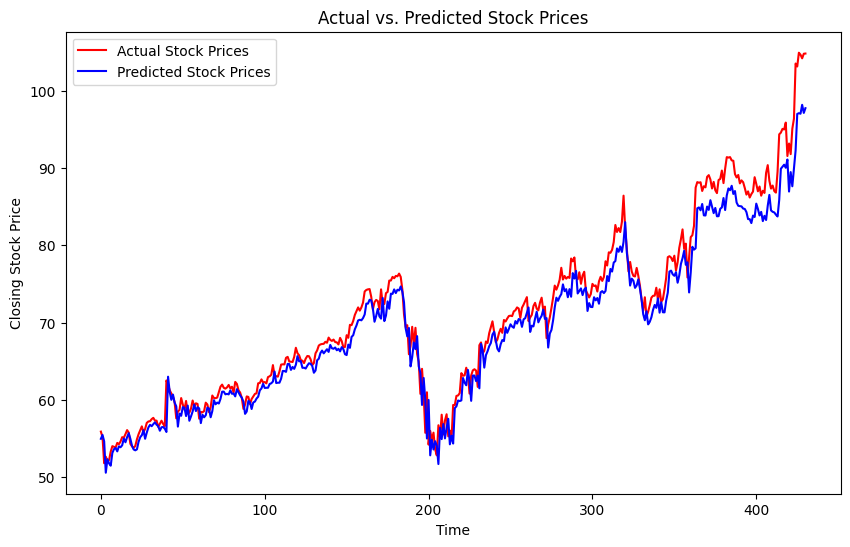

In [ ]:
rmse = evaluate(model, valid_data, scaler)
if rmse < best_rmse:
    best_rmse = rmse
    best_model = model
    best_model_name = 'GRU'

**GRU WITH ATTENTION**

In [ ]:
class Attention(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.score = nn.Linear(hidden_dim, hidden_dim)
    self.softmax = nn.Softmax(dim=2)

  def forward(self, hidden, encoder_outputs):

    # hidden: [batch size, hidden_dim]
    # encoder_outputs: [batch size, seq_len, hidden_dim]

    hidden = hidden.unsqueeze(1) # [batch size, 1, hidden_dim]

    scores = torch.bmm(hidden, encoder_outputs.transpose(1, 2))  # [batch size, 1, seq_len]

    attention_weights = self.softmax(scores) # [batch size, 1, seq_len]

    context_vector = torch.bmm(attention_weights, encoder_outputs) # [batch size, 1, hidden_dim]

    return context_vector.squeeze(1)

class GRUAttention(nn.Module):
    def __init__(self, feature_size, hidden_dim, num_layers):

        super().__init__()

        self.rnn = nn.GRU(feature_size,
                           hidden_dim,
                           batch_first=True,
                           num_layers=num_layers)

        self.attention = Attention(hidden_dim)

        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        # x = [batch size, seq len, feature size]

        output, hidden = self.rnn(x)

        hidden = hidden[-1,:,:] # [batch size, hidden_dim]

        context_vector = self.attention(hidden, output)

        out = self.fc(context_vector)

        return out

In [ ]:
feature_size = 5
hidden_dim = 64
num_layers = 2

model = GRUAttention(feature_size, hidden_dim, num_layers).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

criterion = nn.MSELoss()

In [ ]:
epochs = 100

In [ ]:
for epoch in range(epochs):

    # train the model on the training set
    train_loss = train(model, train_dataloader, criterion, optimizer)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.6f}")

Epoch 10 | Train Loss: 0.000381
Epoch 20 | Train Loss: 0.000136
Epoch 30 | Train Loss: 0.000114
Epoch 40 | Train Loss: 0.000107
Epoch 50 | Train Loss: 0.000076
Epoch 60 | Train Loss: 0.000064
Epoch 70 | Train Loss: 0.000069
Epoch 80 | Train Loss: 0.000073
Epoch 90 | Train Loss: 0.000067
Epoch 100 | Train Loss: 0.000067


RMSE: 1.7392


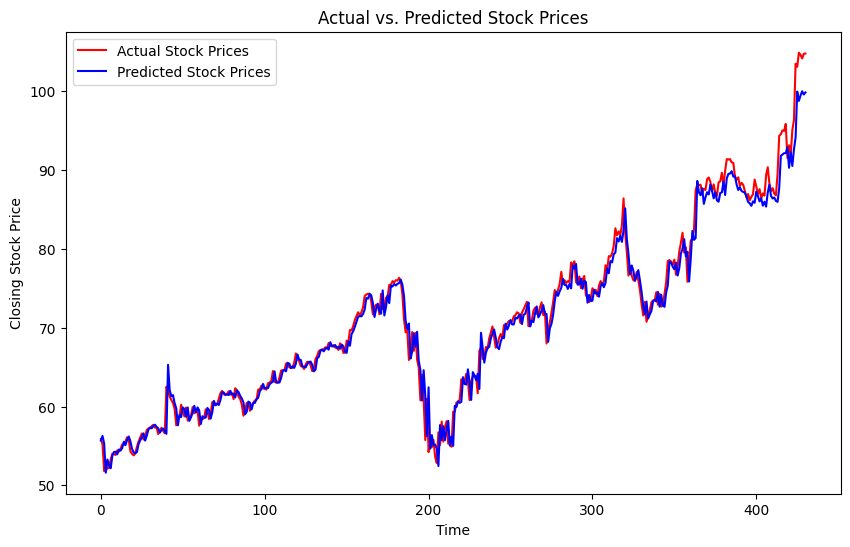

In [ ]:
rmse = evaluate(model, valid_data, scaler)
if rmse < best_rmse:
    best_rmse = rmse
    best_model = model
    best_model_name = 'GRU with Attention'

**TESTING THE BEST MODEL**

In [26]:
print(f"Best model is {best_model_name} with hidden state size {best_hidden_dim}")

Best model is LSTM with hidden state size 32


RMSE: 19.3650


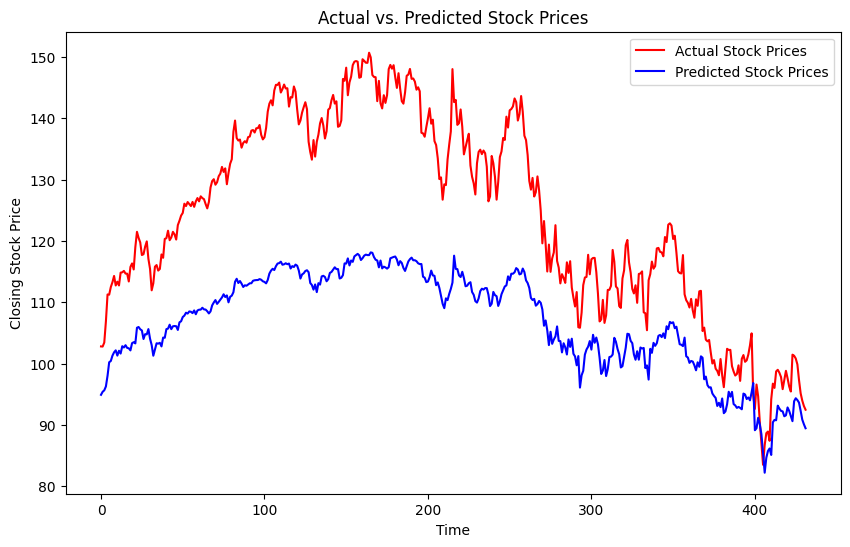

19.365029356065854

In [27]:
evaluate(best_model, test_data, scaler)